# Capstone Project

In this project, we will be creating two Deep Learning models for performing financial time-series predictions on stock prices. <br>
Both models are based on Long Short Term Memory (LSTM) networks , which is a special kind of RNN, capable of learning long-term dependencies. LSTMs were created in order to deal with the "vanishing gradient problem" which is encountered when training traditional RNNs.<br>
**Model 1**: LSTM regressor - we will see how well we can predict future prices for a given asset. <br>
**Model 2**: LSTM classifier - we will see how well we can predict wheter prices for a given asset will go up or down in the future.


# Import relevant libraries

In [1]:
import os
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import torch
import sagemaker
from sagemaker.pytorch import PyTorch, PyTorchModel
from sagemaker.tuner import IntegerParameter, HyperparameterTuner

sagemaker.__version__

'2.16.1'

## Read data 
First step is to load the datasets created during Feature Engineering.<br>
In order to see and better understand how features were generated and what they mean, check the **"feature_engineering.ipynb"** notebook.

In [2]:
# Change some display options for Jupyter Notebook
pd.options.display.max_rows = 20
pd.options.display.max_columns = 500

# Reading the data from CSV files created during feature engineering:
data_dir = "engineered-data"
wege_df = pd.read_csv(os.path.join(data_dir, "wege.csv"), parse_dates=["Date"], index_col=["Date"])
bova_df = pd.read_csv(os.path.join(data_dir, "bova.csv"), parse_dates=["Date"], index_col=["Date"])

### Columns in dataset
These are the columns available at our engineered datasets.<br>
Both datasets have the same columns.

In [3]:
print(wege_df.columns.values)
print(bova_df.columns.values) 

['Open' 'High' 'Low' 'Close' 'Volume [BRL]' 'Volume [shares]'
 'IFR (RSI) [9]' 'True Range [1]' 'Moving Average A [21]'
 'Moving Average E [9]' 'IsLocalPeak' 'IsLocalTrough' 'derivative_peaks'
 'derivative_troughs' 'bear_harami' 'bull_harami' 'bear_engulfing'
 'bull_engulfing' 'hammer' 'shooting_star']
['Open' 'High' 'Low' 'Close' 'Volume [BRL]' 'Volume [shares]'
 'IFR (RSI) [9]' 'True Range [1]' 'Moving Average A [21]'
 'Moving Average E [9]' 'IsLocalPeak' 'IsLocalTrough' 'derivative_peaks'
 'derivative_troughs' 'bear_harami' 'bull_harami' 'bear_engulfing'
 'bull_engulfing' 'hammer' 'shooting_star']


## Prepare data for supervised learning

Since BOVA11 is an ETF which follows the brazilian stock market index IBOVESPA, perhaps it's data could be used as features in order to predict other asset's prices. <br>
In order to do so, and since both datasets have the same column names, we'll rename BOVA11's columns by adding a prefix to their names. This way we can merge the datasets further on.

In [4]:
 # Some features are not going to be used by the model. For instance, we cannot know whether a day was a local peak/trough untill its following day,
 # so we won't use it as input for predicting the next day. For this reason we'll be dropping some columns.
cols_to_drop = ["IsLocalPeak","IsLocalTrough"] 
for df in [wege_df, bova_df]:
    for col in cols_to_drop:
        df.drop(col, axis="columns", inplace=True, errors="ignore")
# Rename the columns in the BOVA11 dataset
dict_colnames = {}
for column in bova_df.columns:
    dict_colnames[column] = "bova_" + column
bova_df.rename(columns=dict_colnames, inplace=True)
bova_df.head()

,bova_Open,bova_High,bova_Low,bova_Close,bova_Volume [BRL],bova_Volume [shares],bova_IFR (RSI) [9],bova_True Range [1],bova_Moving Average A [21],bova_Moving Average E [9],bova_derivative_peaks,bova_derivative_troughs,bova_bear_harami,bova_bull_harami,bova_bear_engulfing,bova_bull_engulfing,bova_hammer,bova_shooting_star
Date,,,,,,,,,,,,,,,,,,
2008-12-02,35.11,35.81,34.91,35.39,26819970.0,759900,NaN,NaN,35.390000,0.00,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0
2008-12-03,34.73,35.40,33.90,35.31,11482717.0,330100,NaN,1.50,35.350000,35.31,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0
2008-12-04,35.80,36.00,35.15,35.70,4554168.0,128400,NaN,0.85,35.466667,35.57,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0
2008-12-05,34.51,35.35,34.11,35.35,6671196.0,193700,NaN,1.59,35.437500,35.46,0.0,0.105,0.0,0.0,0.0,0.0,0.0,0.0
2008-12-08,37.35,38.46,36.95,38.46,3857295.0,103100,NaN,3.11,36.042000,36.66,0.0,0.105,0.0,0.0,0.0,0.0,0.0,0.0


Merge datasets and drop unwanted columns.

In [5]:
complete_df = pd.concat([bova_df, wege_df], axis=1, sort=False)
complete_df.drop(["bova_Date", "Date"], axis="columns", inplace=True, errors='ignore')
complete_df.tail()

,bova_Open,bova_High,bova_Low,bova_Close,bova_Volume [BRL],bova_Volume [shares],bova_IFR (RSI) [9],bova_True Range [1],bova_Moving Average A [21],bova_Moving Average E [9],bova_derivative_peaks,bova_derivative_troughs,bova_bear_harami,bova_bull_harami,bova_bear_engulfing,bova_bull_engulfing,bova_hammer,bova_shooting_star,Open,High,Low,Close,Volume [BRL],Volume [shares],IFR (RSI) [9],True Range [1],Moving Average A [21],Moving Average E [9],derivative_peaks,derivative_troughs,bear_harami,bull_harami,bear_engulfing,bull_engulfing,hammer,shooting_star
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-10-09,94.13,94.99,93.50,93.65,8.611634e+08,9149800.0,52.96,1.49,93.292381,92.710995,-0.143333,0.3025,0.000000,0.0,0.0,0.0,0.0,0.0,74.94,77.18,74.55,76.90,438389500.0,5745100,2.63,84.34,66.217619,71.205888,0.103333,0.0400,0.0,0.0,0.0,0.0,0.0,0.0
2020-10-13,94.10,95.35,93.65,94.80,9.415492e+08,9960394.0,58.07,1.70,93.307619,93.128796,-0.143333,0.3025,0.000000,0.0,0.0,0.0,0.0,0.0,77.88,79.47,77.35,79.15,473625847.0,6030100,2.57,86.84,67.031429,72.794711,0.103333,0.0400,0.0,0.0,0.0,0.0,0.0,0.0
2020-10-14,95.01,95.86,95.01,95.59,1.092614e+09,11431930.0,61.32,1.06,93.263810,93.621037,0.404000,0.3025,0.000000,0.0,0.0,0.0,0.0,0.0,79.26,80.98,79.26,80.58,527948834.0,6579000,1.83,88.19,67.854286,74.351768,0.103333,0.0400,0.0,0.0,0.0,0.0,0.0,0.0
2020-10-15,94.36,95.80,94.05,95.34,9.081088e+08,9544784.0,59.67,1.75,93.210476,93.964830,0.404000,0.5540,0.000000,0.0,0.0,0.0,0.0,0.0,79.64,81.28,78.10,80.77,490407232.0,6096300,3.18,88.37,68.650476,75.635415,0.103333,1.2925,0.0,0.0,0.0,0.0,0.0,0.0
2020-10-16,95.12,95.45,94.54,94.54,9.673009e+08,10188511.0,54.42,0.91,93.145238,94.079864,0.404000,0.5540,1.689655,0.0,0.0,0.0,0.0,0.0,81.06,83.36,80.91,82.05,525025471.0,6355600,2.59,89.56,69.561905,76.918332,0.103333,1.2925,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# taken from: machinelearningmastery.com/blog/

def time_series_to_supervised(data, n_lag=1, n_fut=1, selLag=None, selFut=None, dropnan=True):
    """
    Converts a time series to a supervised learning data set by adding time-shifted prior and future period
    data as input or output (i.e., target result) columns for each period
    :param data:  a series of periodic attributes as a list or NumPy array
    :param n_lag: number of PRIOR periods to lag as input (X); generates: Xa(t-1), Xa(t-2); min= 0 --> nothing lagged
    :param n_fut: number of FUTURE periods to add as target output (y); generates Yout(t+1); min= 0 --> no future periods
    :param selLag:  only copy these specific PRIOR period attributes; default= None; EX: ['Xa', 'Xb' ]
    :param selFut:  only copy these specific FUTURE period attributes; default= None; EX: ['rslt', 'xx']
    :param dropnan: True= drop rows with NaN values; default= True
    :return: a Pandas DataFrame of time series data organized for supervised learning
    NOTES:
    (1) The current period's data is always included in the output.
    (2) A suffix is added to the original column names to indicate a relative time reference: e.g., (t) is the current
        period; (t-2) is from two periods in the past; (t+1) is from the next period
    (3) This is an extension of Jason Brownlee's series_to_supervised() function, customized for MFI use
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    origNames = df.columns
    cols, names = list(), list()
    # include all current period attributes
    cols.append(df.shift(0))
    names += [('%s' % origNames[j]) for j in range(n_vars)]
 
    # lag any past period attributes (t-n_lag,...,t-1)
    n_lag = max(0, n_lag)  # force valid number of lag periods
    for i in range(n_lag, 0, -1):
        suffix= '(t-%d)' % i
        if (None == selLag):   # copy all attributes from PRIOR periods?
            cols.append(df.shift(i))
            names += [('%s%s' % (origNames[j], suffix)) for j in range(n_vars)]
        else:
            for var in (selLag):
                cols.append(df[var].shift(i))
                names+= [('%s%s' % (var, suffix))]
 
    # include future period attributes (t+1,...,t+n_fut)
    n_fut = max(n_fut, 0)  # force valid number of future periods to shift back
    for i in range(1, n_fut + 1):
        suffix= '(t+%d)' % i
        if (None == selFut):  # copy all attributes from future periods?
            cols.append(df.shift(-i))
            names += [('%s%s' % (origNames[j], suffix)) for j in range(n_vars)]
        else:  # copy only selected future attributes
            for var in (selFut):
                cols.append(df[var].shift(-i))
                names += [('%s%s' % (var, suffix))]
    # combine everything
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values introduced by lagging
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [7]:
data = time_series_to_supervised(complete_df, n_lag=5, n_fut=1, selFut=["Close"], dropnan=True)
data

,bova_Open,bova_High,bova_Low,bova_Close,bova_Volume [BRL],bova_Volume [shares],bova_IFR (RSI) [9],bova_True Range [1],bova_Moving Average A [21],bova_Moving Average E [9],bova_derivative_peaks,bova_derivative_troughs,bova_bear_harami,bova_bull_harami,bova_bear_engulfing,bova_bull_engulfing,bova_hammer,bova_shooting_star,Open,High,Low,Close,Volume [BRL],Volume [shares],IFR (RSI) [9],True Range [1],Moving Average A [21],Moving Average E [9],derivative_peaks,derivative_troughs,bear_harami,bull_harami,bear_engulfing,bull_engulfing,hammer,shooting_star,bova_Open(t-5),bova_High(t-5),bova_Low(t-5),bova_Close(t-5),bova_Volume [BRL](t-5),bova_Volume [shares](t-5),bova_IFR (RSI) [9](t-5),bova_True Range [1](t-5),bova_Moving Average A [21](t-5),bova_Moving Average E [9](t-5),bova_derivative_peaks(t-5),bova_derivative_troughs(t-5),bova_bear_harami(t-5),bova_bull_harami(t-5),bova_bear_engulfing(t-5),bova_bull_engulfing(t-5),bova_hammer(t-5),bova_shooting_star(t-5),Open(t-5),High(t-5),Low(t-5),Close(t-5),Volume [BRL](t-5),Volume [shares](t-5),IFR (RSI) [9](t-5),True Range [1](t-5),Moving Average A [21](t-5),Moving Average E [9](t-5),derivative_peaks(t-5),derivative_troughs(t-5),bear_harami(t-5),bull_harami(t-5),bear_engulfing(t-5),bull_engulfing(t-5),hammer(t-5),shooting_star(t-5),bova_Open(t-4),bova_High(t-4),bova_Low(t-4),bova_Close(t-4),bova_Volume [BRL](t-4),bova_Volume [shares](t-4),bova_IFR (RSI) [9](t-4),bova_True Range [1](t-4),bova_Moving Average A [21](t-4),bova_Moving Average E [9](t-4),bova_derivative_peaks(t-4),bova_derivative_troughs(t-4),bova_bear_harami(t-4),bova_bull_harami(t-4),bova_bear_engulfing(t-4),bova_bull_engulfing(t-4),bova_hammer(t-4),bova_shooting_star(t-4),Open(t-4),High(t-4),Low(t-4),Close(t-4),Volume [BRL](t-4),Volume [shares](t-4),IFR (RSI) [9](t-4),True Range [1](t-4),Moving Average A [21](t-4),Moving Average E [9](t-4),derivative_peaks(t-4),derivative_troughs(t-4),bear_harami(t-4),bull_harami(t-4),bear_engulfing(t-4),bull_engulfing(t-4),hammer(t-4),shooting_star(t-4),bova_Open(t-3),bova_High(t-3),bova_Low(t-3),bova_Close(t-3),bova_Volume [BRL](t-3),bova_Volume [shares](t-3),bova_IFR (RSI) [9](t-3),bova_True Range [1](t-3),bova_Moving Average A [21](t-3),bova_Moving Average E [9](t-3),bova_derivative_peaks(t-3),bova_derivative_troughs(t-3),bova_bear_harami(t-3),bova_bull_harami(t-3),bova_bear_engulfing(t-3),bova_bull_engulfing(t-3),bova_hammer(t-3),bova_shooting_star(t-3),Open(t-3),High(t-3),Low(t-3),Close(t-3),Volume [BRL](t-3),Volume [shares](t-3),IFR (RSI) [9](t-3),True Range [1](t-3),Moving Average A [21](t-3),Moving Average E [9](t-3),derivative_peaks(t-3),derivative_troughs(t-3),bear_harami(t-3),bull_harami(t-3),bear_engulfing(t-3),bull_engulfing(t-3),hammer(t-3),shooting_star(t-3),bova_Open(t-2),bova_High(t-2),bova_Low(t-2),bova_Close(t-2),bova_Volume [BRL](t-2),bova_Volume [shares](t-2),bova_IFR (RSI) [9](t-2),bova_True Range [1](t-2),bova_Moving Average A [21](t-2),bova_Moving Average E [9](t-2),bova_derivative_peaks(t-2),bova_derivative_troughs(t-2),bova_bear_harami(t-2),bova_bull_harami(t-2),bova_bear_engulfing(t-2),bova_bull_engulfing(t-2),bova_hammer(t-2),bova_shooting_star(t-2),Open(t-2),High(t-2),Low(t-2),Close(t-2),Volume [BRL](t-2),Volume [shares](t-2),IFR (RSI) [9](t-2),True Range [1](t-2),Moving Average A [21](t-2),Moving Average E [9](t-2),derivative_peaks(t-2),derivative_troughs(t-2),bear_harami(t-2),bull_harami(t-2),bear_engulfing(t-2),bull_engulfing(t-2),hammer(t-2),shooting_star(t-2),bova_Open(t-1),bova_High(t-1),bova_Low(t-1),bova_Close(t-1),bova_Volume [BRL](t-1),bova_Volume [shares](t-1),bova_IFR (RSI) [9](t-1),bova_True Range [1](t-1),bova_Moving Average A [21](t-1),bova_Moving Average E [9](t-1),bova_derivative_peaks(t-1),bova_derivative_troughs(t-1),bova_bear_harami(t-1),bova_bull_harami(t-1),bova_bear_engulfing(t-1),bova_bull_engulfing(t-1),bova_hammer(t-1),bova_shooting_star(t-1),Open(t-1),High(t-1),Low(t-1),Close(t-1),Volume [BRL](t-1),Volume [shares](t-1),IFR (RSI) [9](t-1)

### Split train/test data

We will use all the available data up untill September 15th, 2020 as our training set. <br>
The remaining days, which correspond to two months of operations will represent our test set.

In [8]:
cut_off = datetime(2020, 8, 15)
train_df = data[data.index <= cut_off]
test_df = data[data.index > cut_off]


In [9]:
print(f"First/Last day in training set: {train_df.index[0].date()} / {train_df.index[-1].date()}")
print(f"train_df shape: {train_df.shape}")
train_df

First/Last day in training set: 2008-12-19 / 2020-08-14
train_df shape: (2880, 217)


,bova_Open,bova_High,bova_Low,bova_Close,bova_Volume [BRL],bova_Volume [shares],bova_IFR (RSI) [9],bova_True Range [1],bova_Moving Average A [21],bova_Moving Average E [9],bova_derivative_peaks,bova_derivative_troughs,bova_bear_harami,bova_bull_harami,bova_bear_engulfing,bova_bull_engulfing,bova_hammer,bova_shooting_star,Open,High,Low,Close,Volume [BRL],Volume [shares],IFR (RSI) [9],True Range [1],Moving Average A [21],Moving Average E [9],derivative_peaks,derivative_troughs,bear_harami,bull_harami,bear_engulfing,bull_engulfing,hammer,shooting_star,bova_Open(t-5),bova_High(t-5),bova_Low(t-5),bova_Close(t-5),bova_Volume [BRL](t-5),bova_Volume [shares](t-5),bova_IFR (RSI) [9](t-5),bova_True Range [1](t-5),bova_Moving Average A [21](t-5),bova_Moving Average E [9](t-5),bova_derivative_peaks(t-5),bova_derivative_troughs(t-5),bova_bear_harami(t-5),bova_bull_harami(t-5),bova_bear_engulfing(t-5),bova_bull_engulfing(t-5),bova_hammer(t-5),bova_shooting_star(t-5),Open(t-5),High(t-5),Low(t-5),Close(t-5),Volume [BRL](t-5),Volume [shares](t-5),IFR (RSI) [9](t-5),True Range [1](t-5),Moving Average A [21](t-5),Moving Average E [9](t-5),derivative_peaks(t-5),derivative_troughs(t-5),bear_harami(t-5),bull_harami(t-5),bear_engulfing(t-5),bull_engulfing(t-5),hammer(t-5),shooting_star(t-5),bova_Open(t-4),bova_High(t-4),bova_Low(t-4),bova_Close(t-4),bova_Volume [BRL](t-4),bova_Volume [shares](t-4),bova_IFR (RSI) [9](t-4),bova_True Range [1](t-4),bova_Moving Average A [21](t-4),bova_Moving Average E [9](t-4),bova_derivative_peaks(t-4),bova_derivative_troughs(t-4),bova_bear_harami(t-4),bova_bull_harami(t-4),bova_bear_engulfing(t-4),bova_bull_engulfing(t-4),bova_hammer(t-4),bova_shooting_star(t-4),Open(t-4),High(t-4),Low(t-4),Close(t-4),Volume [BRL](t-4),Volume [shares](t-4),IFR (RSI) [9](t-4),True Range [1](t-4),Moving Average A [21](t-4),Moving Average E [9](t-4),derivative_peaks(t-4),derivative_troughs(t-4),bear_harami(t-4),bull_harami(t-4),bear_engulfing(t-4),bull_engulfing(t-4),hammer(t-4),shooting_star(t-4),bova_Open(t-3),bova_High(t-3),bova_Low(t-3),bova_Close(t-3),bova_Volume [BRL](t-3),bova_Volume [shares](t-3),bova_IFR (RSI) [9](t-3),bova_True Range [1](t-3),bova_Moving Average A [21](t-3),bova_Moving Average E [9](t-3),bova_derivative_peaks(t-3),bova_derivative_troughs(t-3),bova_bear_harami(t-3),bova_bull_harami(t-3),bova_bear_engulfing(t-3),bova_bull_engulfing(t-3),bova_hammer(t-3),bova_shooting_star(t-3),Open(t-3),High(t-3),Low(t-3),Close(t-3),Volume [BRL](t-3),Volume [shares](t-3),IFR (RSI) [9](t-3),True Range [1](t-3),Moving Average A [21](t-3),Moving Average E [9](t-3),derivative_peaks(t-3),derivative_troughs(t-3),bear_harami(t-3),bull_harami(t-3),bear_engulfing(t-3),bull_engulfing(t-3),hammer(t-3),shooting_star(t-3),bova_Open(t-2),bova_High(t-2),bova_Low(t-2),bova_Close(t-2),bova_Volume [BRL](t-2),bova_Volume [shares](t-2),bova_IFR (RSI) [9](t-2),bova_True Range [1](t-2),bova_Moving Average A [21](t-2),bova_Moving Average E [9](t-2),bova_derivative_peaks(t-2),bova_derivative_troughs(t-2),bova_bear_harami(t-2),bova_bull_harami(t-2),bova_bear_engulfing(t-2),bova_bull_engulfing(t-2),bova_hammer(t-2),bova_shooting_star(t-2),Open(t-2),High(t-2),Low(t-2),Close(t-2),Volume [BRL](t-2),Volume [shares](t-2),IFR (RSI) [9](t-2),True Range [1](t-2),Moving Average A [21](t-2),Moving Average E [9](t-2),derivative_peaks(t-2),derivative_troughs(t-2),bear_harami(t-2),bull_harami(t-2),bear_engulfing(t-2),bull_engulfing(t-2),hammer(t-2),shooting_star(t-2),bova_Open(t-1),bova_High(t-1),bova_Low(t-1),bova_Close(t-1),bova_Volume [BRL](t-1),bova_Volume [shares](t-1),bova_IFR (RSI) [9](t-1),bova_True Range [1](t-1),bova_Moving Average A [21](t-1),bova_Moving Average E [9](t-1),bova_derivative_peaks(t-1),bova_derivative_troughs(t-1),bova_bear_harami(t-1),bova_bull_harami(t-1),bova_bear_engulfing(t-1),bova_bull_engulfing(t-1),bova_hammer(t-1),bova_shooting_star(t-1),Open(t-1),High(t-1),Low(t-1),Close(t-1),Volume [BRL](t-1),Volume [shares](t-1),IFR (RSI) [9](t-1)

In [10]:
print(f"First/Last day in test set: {test_df.index[0].date()} / {test_df.index[-1].date()}")
print(f"test_df shape:{test_df.shape}")
test_df

First/Last day in test set: 2020-08-17 / 2020-10-15
test_df shape:(42, 217)


,bova_Open,bova_High,bova_Low,bova_Close,bova_Volume [BRL],bova_Volume [shares],bova_IFR (RSI) [9],bova_True Range [1],bova_Moving Average A [21],bova_Moving Average E [9],bova_derivative_peaks,bova_derivative_troughs,bova_bear_harami,bova_bull_harami,bova_bear_engulfing,bova_bull_engulfing,bova_hammer,bova_shooting_star,Open,High,Low,Close,Volume [BRL],Volume [shares],IFR (RSI) [9],True Range [1],Moving Average A [21],Moving Average E [9],derivative_peaks,derivative_troughs,bear_harami,bull_harami,bear_engulfing,bull_engulfing,hammer,shooting_star,bova_Open(t-5),bova_High(t-5),bova_Low(t-5),bova_Close(t-5),bova_Volume [BRL](t-5),bova_Volume [shares](t-5),bova_IFR (RSI) [9](t-5),bova_True Range [1](t-5),bova_Moving Average A [21](t-5),bova_Moving Average E [9](t-5),bova_derivative_peaks(t-5),bova_derivative_troughs(t-5),bova_bear_harami(t-5),bova_bull_harami(t-5),bova_bear_engulfing(t-5),bova_bull_engulfing(t-5),bova_hammer(t-5),bova_shooting_star(t-5),Open(t-5),High(t-5),Low(t-5),Close(t-5),Volume [BRL](t-5),Volume [shares](t-5),IFR (RSI) [9](t-5),True Range [1](t-5),Moving Average A [21](t-5),Moving Average E [9](t-5),derivative_peaks(t-5),derivative_troughs(t-5),bear_harami(t-5),bull_harami(t-5),bear_engulfing(t-5),bull_engulfing(t-5),hammer(t-5),shooting_star(t-5),bova_Open(t-4),bova_High(t-4),bova_Low(t-4),bova_Close(t-4),bova_Volume [BRL](t-4),bova_Volume [shares](t-4),bova_IFR (RSI) [9](t-4),bova_True Range [1](t-4),bova_Moving Average A [21](t-4),bova_Moving Average E [9](t-4),bova_derivative_peaks(t-4),bova_derivative_troughs(t-4),bova_bear_harami(t-4),bova_bull_harami(t-4),bova_bear_engulfing(t-4),bova_bull_engulfing(t-4),bova_hammer(t-4),bova_shooting_star(t-4),Open(t-4),High(t-4),Low(t-4),Close(t-4),Volume [BRL](t-4),Volume [shares](t-4),IFR (RSI) [9](t-4),True Range [1](t-4),Moving Average A [21](t-4),Moving Average E [9](t-4),derivative_peaks(t-4),derivative_troughs(t-4),bear_harami(t-4),bull_harami(t-4),bear_engulfing(t-4),bull_engulfing(t-4),hammer(t-4),shooting_star(t-4),bova_Open(t-3),bova_High(t-3),bova_Low(t-3),bova_Close(t-3),bova_Volume [BRL](t-3),bova_Volume [shares](t-3),bova_IFR (RSI) [9](t-3),bova_True Range [1](t-3),bova_Moving Average A [21](t-3),bova_Moving Average E [9](t-3),bova_derivative_peaks(t-3),bova_derivative_troughs(t-3),bova_bear_harami(t-3),bova_bull_harami(t-3),bova_bear_engulfing(t-3),bova_bull_engulfing(t-3),bova_hammer(t-3),bova_shooting_star(t-3),Open(t-3),High(t-3),Low(t-3),Close(t-3),Volume [BRL](t-3),Volume [shares](t-3),IFR (RSI) [9](t-3),True Range [1](t-3),Moving Average A [21](t-3),Moving Average E [9](t-3),derivative_peaks(t-3),derivative_troughs(t-3),bear_harami(t-3),bull_harami(t-3),bear_engulfing(t-3),bull_engulfing(t-3),hammer(t-3),shooting_star(t-3),bova_Open(t-2),bova_High(t-2),bova_Low(t-2),bova_Close(t-2),bova_Volume [BRL](t-2),bova_Volume [shares](t-2),bova_IFR (RSI) [9](t-2),bova_True Range [1](t-2),bova_Moving Average A [21](t-2),bova_Moving Average E [9](t-2),bova_derivative_peaks(t-2),bova_derivative_troughs(t-2),bova_bear_harami(t-2),bova_bull_harami(t-2),bova_bear_engulfing(t-2),bova_bull_engulfing(t-2),bova_hammer(t-2),bova_shooting_star(t-2),Open(t-2),High(t-2),Low(t-2),Close(t-2),Volume [BRL](t-2),Volume [shares](t-2),IFR (RSI) [9](t-2),True Range [1](t-2),Moving Average A [21](t-2),Moving Average E [9](t-2),derivative_peaks(t-2),derivative_troughs(t-2),bear_harami(t-2),bull_harami(t-2),bear_engulfing(t-2),bull_engulfing(t-2),hammer(t-2),shooting_star(t-2),bova_Open(t-1),bova_High(t-1),bova_Low(t-1),bova_Close(t-1),bova_Volume [BRL](t-1),bova_Volume [shares](t-1),bova_IFR (RSI) [9](t-1),bova_True Range [1](t-1),bova_Moving Average A [21](t-1),bova_Moving Average E [9](t-1),bova_derivative_peaks(t-1),bova_derivative_troughs(t-1),bova_bear_harami(t-1),bova_bull_harami(t-1),bova_bear_engulfing(t-1),bova_bull_engulfing(t-1),bova_hammer(t-1),bova_shooting_star(t-1),Open(t-1),High(t-1),Low(t-1),Close(t-1),Volume [BRL](t-1),Volume [shares](t-1),IFR (RSI) [9](t-1)

In [11]:
def get_scaler_and_scaled_data(df, col_name, feature_range=None):
    '''
    Returns the scaled values of a given df column into a feature_range which can be selected by the user automatically set.
    df: dataframe whose column's scaled values are wanted
    col_name: name of the column from df from which the scaled values should be calculated.
    feature_range: range of values. If None it will be automatically set.
    return: scaler: object which can be used to perform inverse tranformation when needed.
    return: scaled_values: the scaled values
    '''
    if feature_range is None:
        feature_range = (-1, 1) if min(df[col_name].values) < 0 else (0, 1)
    scaler = MinMaxScaler(feature_range=feature_range)
    scaled_values = scaler.fit_transform(df[col_name].values.reshape(-1, 1))
    return scaler, scaled_values

# Regression Model

## Scale data

In [12]:
dict_scalers = {}
train_df_scaled = pd.DataFrame(index=train_df.index)
test_df_scaled = pd.DataFrame(index=test_df.index)

for column_name in train_df.columns:
    if pd.api.types.is_numeric_dtype(train_df[column_name]):
        scaler, train_df_scaled[column_name] = get_scaler_and_scaled_data(train_df, column_name)
        test_df_scaled[column_name] = scaler.transform(test_df[column_name].values.reshape(-1, 1))
        dict_scalers[column_name] = scaler

In [13]:
train_df_scaled

,bova_Open,bova_High,bova_Low,bova_Close,bova_Volume [BRL],bova_Volume [shares],bova_IFR (RSI) [9],bova_True Range [1],bova_Moving Average A [21],bova_Moving Average E [9],bova_derivative_peaks,bova_derivative_troughs,bova_bear_harami,bova_bull_harami,bova_bear_engulfing,bova_bull_engulfing,bova_hammer,bova_shooting_star,Open,High,Low,Close,Volume [BRL],Volume [shares],IFR (RSI) [9],True Range [1],Moving Average A [21],Moving Average E [9],derivative_peaks,derivative_troughs,bear_harami,bull_harami,bear_engulfing,bull_engulfing,hammer,shooting_star,bova_Open(t-5),bova_High(t-5),bova_Low(t-5),bova_Close(t-5),bova_Volume [BRL](t-5),bova_Volume [shares](t-5),bova_IFR (RSI) [9](t-5),bova_True Range [1](t-5),bova_Moving Average A [21](t-5),bova_Moving Average E [9](t-5),bova_derivative_peaks(t-5),bova_derivative_troughs(t-5),bova_bear_harami(t-5),bova_bull_harami(t-5),bova_bear_engulfing(t-5),bova_bull_engulfing(t-5),bova_hammer(t-5),bova_shooting_star(t-5),Open(t-5),High(t-5),Low(t-5),Close(t-5),Volume [BRL](t-5),Volume [shares](t-5),IFR (RSI) [9](t-5),True Range [1](t-5),Moving Average A [21](t-5),Moving Average E [9](t-5),derivative_peaks(t-5),derivative_troughs(t-5),bear_harami(t-5),bull_harami(t-5),bear_engulfing(t-5),bull_engulfing(t-5),hammer(t-5),shooting_star(t-5),bova_Open(t-4),bova_High(t-4),bova_Low(t-4),bova_Close(t-4),bova_Volume [BRL](t-4),bova_Volume [shares](t-4),bova_IFR (RSI) [9](t-4),bova_True Range [1](t-4),bova_Moving Average A [21](t-4),bova_Moving Average E [9](t-4),bova_derivative_peaks(t-4),bova_derivative_troughs(t-4),bova_bear_harami(t-4),bova_bull_harami(t-4),bova_bear_engulfing(t-4),bova_bull_engulfing(t-4),bova_hammer(t-4),bova_shooting_star(t-4),Open(t-4),High(t-4),Low(t-4),Close(t-4),Volume [BRL](t-4),Volume [shares](t-4),IFR (RSI) [9](t-4),True Range [1](t-4),Moving Average A [21](t-4),Moving Average E [9](t-4),derivative_peaks(t-4),derivative_troughs(t-4),bear_harami(t-4),bull_harami(t-4),bear_engulfing(t-4),bull_engulfing(t-4),hammer(t-4),shooting_star(t-4),bova_Open(t-3),bova_High(t-3),bova_Low(t-3),bova_Close(t-3),bova_Volume [BRL](t-3),bova_Volume [shares](t-3),bova_IFR (RSI) [9](t-3),bova_True Range [1](t-3),bova_Moving Average A [21](t-3),bova_Moving Average E [9](t-3),bova_derivative_peaks(t-3),bova_derivative_troughs(t-3),bova_bear_harami(t-3),bova_bull_harami(t-3),bova_bear_engulfing(t-3),bova_bull_engulfing(t-3),bova_hammer(t-3),bova_shooting_star(t-3),Open(t-3),High(t-3),Low(t-3),Close(t-3),Volume [BRL](t-3),Volume [shares](t-3),IFR (RSI) [9](t-3),True Range [1](t-3),Moving Average A [21](t-3),Moving Average E [9](t-3),derivative_peaks(t-3),derivative_troughs(t-3),bear_harami(t-3),bull_harami(t-3),bear_engulfing(t-3),bull_engulfing(t-3),hammer(t-3),shooting_star(t-3),bova_Open(t-2),bova_High(t-2),bova_Low(t-2),bova_Close(t-2),bova_Volume [BRL](t-2),bova_Volume [shares](t-2),bova_IFR (RSI) [9](t-2),bova_True Range [1](t-2),bova_Moving Average A [21](t-2),bova_Moving Average E [9](t-2),bova_derivative_peaks(t-2),bova_derivative_troughs(t-2),bova_bear_harami(t-2),bova_bull_harami(t-2),bova_bear_engulfing(t-2),bova_bull_engulfing(t-2),bova_hammer(t-2),bova_shooting_star(t-2),Open(t-2),High(t-2),Low(t-2),Close(t-2),Volume [BRL](t-2),Volume [shares](t-2),IFR (RSI) [9](t-2),True Range [1](t-2),Moving Average A [21](t-2),Moving Average E [9](t-2),derivative_peaks(t-2),derivative_troughs(t-2),bear_harami(t-2),bull_harami(t-2),bear_engulfing(t-2),bull_engulfing(t-2),hammer(t-2),shooting_star(t-2),bova_Open(t-1),bova_High(t-1),bova_Low(t-1),bova_Close(t-1),bova_Volume [BRL](t-1),bova_Volume [shares](t-1),bova_IFR (RSI) [9](t-1),bova_True Range [1](t-1),bova_Moving Average A [21](t-1),bova_Moving Average E [9](t-1),bova_derivative_peaks(t-1),bova_derivative_troughs(t-1),bova_bear_harami(t-1),bova_bull_harami(t-1),bova_bear_engulfing(t-1),bova_bull_engulfing(t-1),bova_hammer(t-1),bova_shooting_star(t-1),Open(t-1),High(t-1),Low(t-1),Close(t-1),Volume [BRL](t-1),Volume [shares](t-1),IFR (RSI) [9](t-1)

In [14]:
test_df_scaled

,bova_Open,bova_High,bova_Low,bova_Close,bova_Volume [BRL],bova_Volume [shares],bova_IFR (RSI) [9],bova_True Range [1],bova_Moving Average A [21],bova_Moving Average E [9],bova_derivative_peaks,bova_derivative_troughs,bova_bear_harami,bova_bull_harami,bova_bear_engulfing,bova_bull_engulfing,bova_hammer,bova_shooting_star,Open,High,Low,Close,Volume [BRL],Volume [shares],IFR (RSI) [9],True Range [1],Moving Average A [21],Moving Average E [9],derivative_peaks,derivative_troughs,bear_harami,bull_harami,bear_engulfing,bull_engulfing,hammer,shooting_star,bova_Open(t-5),bova_High(t-5),bova_Low(t-5),bova_Close(t-5),bova_Volume [BRL](t-5),bova_Volume [shares](t-5),bova_IFR (RSI) [9](t-5),bova_True Range [1](t-5),bova_Moving Average A [21](t-5),bova_Moving Average E [9](t-5),bova_derivative_peaks(t-5),bova_derivative_troughs(t-5),bova_bear_harami(t-5),bova_bull_harami(t-5),bova_bear_engulfing(t-5),bova_bull_engulfing(t-5),bova_hammer(t-5),bova_shooting_star(t-5),Open(t-5),High(t-5),Low(t-5),Close(t-5),Volume [BRL](t-5),Volume [shares](t-5),IFR (RSI) [9](t-5),True Range [1](t-5),Moving Average A [21](t-5),Moving Average E [9](t-5),derivative_peaks(t-5),derivative_troughs(t-5),bear_harami(t-5),bull_harami(t-5),bear_engulfing(t-5),bull_engulfing(t-5),hammer(t-5),shooting_star(t-5),bova_Open(t-4),bova_High(t-4),bova_Low(t-4),bova_Close(t-4),bova_Volume [BRL](t-4),bova_Volume [shares](t-4),bova_IFR (RSI) [9](t-4),bova_True Range [1](t-4),bova_Moving Average A [21](t-4),bova_Moving Average E [9](t-4),bova_derivative_peaks(t-4),bova_derivative_troughs(t-4),bova_bear_harami(t-4),bova_bull_harami(t-4),bova_bear_engulfing(t-4),bova_bull_engulfing(t-4),bova_hammer(t-4),bova_shooting_star(t-4),Open(t-4),High(t-4),Low(t-4),Close(t-4),Volume [BRL](t-4),Volume [shares](t-4),IFR (RSI) [9](t-4),True Range [1](t-4),Moving Average A [21](t-4),Moving Average E [9](t-4),derivative_peaks(t-4),derivative_troughs(t-4),bear_harami(t-4),bull_harami(t-4),bear_engulfing(t-4),bull_engulfing(t-4),hammer(t-4),shooting_star(t-4),bova_Open(t-3),bova_High(t-3),bova_Low(t-3),bova_Close(t-3),bova_Volume [BRL](t-3),bova_Volume [shares](t-3),bova_IFR (RSI) [9](t-3),bova_True Range [1](t-3),bova_Moving Average A [21](t-3),bova_Moving Average E [9](t-3),bova_derivative_peaks(t-3),bova_derivative_troughs(t-3),bova_bear_harami(t-3),bova_bull_harami(t-3),bova_bear_engulfing(t-3),bova_bull_engulfing(t-3),bova_hammer(t-3),bova_shooting_star(t-3),Open(t-3),High(t-3),Low(t-3),Close(t-3),Volume [BRL](t-3),Volume [shares](t-3),IFR (RSI) [9](t-3),True Range [1](t-3),Moving Average A [21](t-3),Moving Average E [9](t-3),derivative_peaks(t-3),derivative_troughs(t-3),bear_harami(t-3),bull_harami(t-3),bear_engulfing(t-3),bull_engulfing(t-3),hammer(t-3),shooting_star(t-3),bova_Open(t-2),bova_High(t-2),bova_Low(t-2),bova_Close(t-2),bova_Volume [BRL](t-2),bova_Volume [shares](t-2),bova_IFR (RSI) [9](t-2),bova_True Range [1](t-2),bova_Moving Average A [21](t-2),bova_Moving Average E [9](t-2),bova_derivative_peaks(t-2),bova_derivative_troughs(t-2),bova_bear_harami(t-2),bova_bull_harami(t-2),bova_bear_engulfing(t-2),bova_bull_engulfing(t-2),bova_hammer(t-2),bova_shooting_star(t-2),Open(t-2),High(t-2),Low(t-2),Close(t-2),Volume [BRL](t-2),Volume [shares](t-2),IFR (RSI) [9](t-2),True Range [1](t-2),Moving Average A [21](t-2),Moving Average E [9](t-2),derivative_peaks(t-2),derivative_troughs(t-2),bear_harami(t-2),bull_harami(t-2),bear_engulfing(t-2),bull_engulfing(t-2),hammer(t-2),shooting_star(t-2),bova_Open(t-1),bova_High(t-1),bova_Low(t-1),bova_Close(t-1),bova_Volume [BRL](t-1),bova_Volume [shares](t-1),bova_IFR (RSI) [9](t-1),bova_True Range [1](t-1),bova_Moving Average A [21](t-1),bova_Moving Average E [9](t-1),bova_derivative_peaks(t-1),bova_derivative_troughs(t-1),bova_bear_harami(t-1),bova_bull_harami(t-1),bova_bear_engulfing(t-1),bova_bull_engulfing(t-1),bova_hammer(t-1),bova_shooting_star(t-1),Open(t-1),High(t-1),Low(t-1),Close(t-1),Volume [BRL](t-1),Volume [shares](t-1),IFR (RSI) [9](t-1)

## Save data locally

In [15]:
train_data_dir = 'train_data'
train_df_scaled.to_csv(os.path.join(train_data_dir, 'train.csv'), columns=data.columns.values[::-1], header=False, index=False)

In [16]:
test_data_dir = 'test_data'
test_df_scaled.to_csv(os.path.join(test_data_dir, 'test.csv'), columns=data.columns.values[::-1], header=False, index=False)

## Upload train data do S3

In [17]:
sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/capstone'

role = sagemaker.get_execution_role()

In [18]:
input_data = sagemaker_session.upload_data(path=train_data_dir, bucket=bucket, key_prefix=prefix)
validation_data = sagemaker_session.upload_data(path=test_data_dir, bucket=bucket, key_prefix=prefix)

## Build and train the model

In [50]:
!pygmentize train/model.py

^C
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/pygmentize", line 10, in <module>
    sys.exit(main())
  File "/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/pygments/cmdline.py", line 548, in main
    return main_inner(popts, args, usage)
  File "/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/pygments/cmdline.py", line 383, in main_inner
    lexer = get_lexer_for_filename(infn, code, **parsed_opts)
  File "/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/pygments/lexers/__init__.py", line 208, in get_lexer_for_filename
    res = find_lexer_class_for_filename(_fn, code)
  File "/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/pygments/lexers/__init__.py", line 173, in find_lexer_class_for_filename
    for cls in find_plugin_lexers():
  File "/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/pygm

In [51]:
!pygmentize train/train.py

import argparse
import json
import os
import pickle
import sys
import sagemaker_containers
import pandas as pd
import torch
import torch.optim as optim
import torch.utils.data

from model import LSTM

def model_fn(model_dir):
    """Load the PyTorch model from the `model_dir` directory."""
    print("Loading model.")

    # First, load the parameters used to create the model.
    model_info = {}
    model_info_path = os.path.join(model_dir, 'model_info.pth')
    with open(model_info_path, 'rb') as f:
        model_info = torch.load(f)

    print("model_info: {}".format(model_info))

    # Determine the device and construct the model.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LSTM(model_info['input_dim'], model_info['hidden_dim'], model_info['num_layers'], model_info['output_dim'])

    # Load the stored model parameters.
    model_path = os.path.join(model_dir, 'model.pth')
    with open(model_path, 'rb') as f:
        model.load_state_dict(t

In [79]:
hyperparameters = {
                'epochs': 200,
                'input_dim': train_df.shape[-1] - 1,
                'hidden_dim': int((2/3) * (train_df.shape[-1])),
                'num_layers': 1,
                'output_dim': 1,
                }
lstm = PyTorch(entry_point="train.py",
                    source_dir="train",
                    role=role,
                    framework_version='0.4.0',
                    py_version="py3",
                    instance_count=1,
                    instance_type='ml.m4.xlarge',
                    hyperparameters=hyperparameters)
lstm.hyperparameters()

{'epochs': '200',
 'input_dim': '216',
 'hidden_dim': '144',
 'num_layers': '1',
 'output_dim': '1'}

### Hyperparameter tuning

In [80]:
min_hd = 5 * int(len(train_df.index)/(10 * train_df.shape[-1]))
max_hd = 30 * int(len(train_df.index)/(1 * train_df.shape[-1]))
print(min_hd,max_hd)

metric_definitions = [{'Name': 'validation:rmse',
                       'Regex': 'val_MSE: (.*?);'}]
lstm_hyperparameter_tuner = HyperparameterTuner(estimator=lstm,
                                               objective_metric_name = "validation:rmse",
                                               objective_type="Minimize",
                                               metric_definitions=metric_definitions,
                                               max_jobs=10,
                                               max_parallel_jobs=2,
                                               hyperparameter_ranges={
                                                   'hidden_dim' : IntegerParameter(min_hd, max_hd),
                                                   'num_layers' : IntegerParameter(1, 2)
                                               })

5 390


In [83]:
# only run when no model is already available in s3
tuning_job_name = "lstm-tuning-1"
print(tuning_job_name)
lstm_hyperparameter_tuner.fit({'training': input_data,'validation': validation_data}, job_name=tuning_job_name)

lstm-tuning-1
...................................................................................................................................................................................................................................................................!


In [85]:
# only run when no model is already available in s3
print(lstm_hyperparameter_tuner.best_training_job())
lstm = lstm_hyperparameter_tuner.best_estimator()

lstm-tuning-1-008-0156fc53

2020-11-05 01:38:24 Starting - Preparing the instances for training
2020-11-05 01:38:24 Downloading - Downloading input data
2020-11-05 01:38:24 Training - Training image download completed. Training in progress.
2020-11-05 01:38:24 Uploading - Uploading generated training model
2020-11-05 01:38:24 Completed - Training job completed


## Deploy the model

In [86]:
# only run when no model is already available in s3
%% time
predictor = lstm.deploy(initial_instance_count = 1, instance_type = 'ml.t2.medium', endpoint_name="lstm-regressor-endpoint")

UsageError: Line magic function `%%time` not found.


In [87]:
# run to load already deployed model!!
predictor = sagemaker.pytorch.PyTorchPredictor(endpoint_name="lstm-regressor-endpoint")

In [88]:
train_data = pd.read_csv(os.path.join(train_data_dir, "train.csv"), header=None, names=None)
    
train_y = train_data[[0]].values
train_y = torch.from_numpy(train_y).float()

train_X = train_data.drop([0], axis=1).values
train_X = torch.from_numpy(train_X).float().unsqueeze(1)
print(train_X.size())

torch.Size([2880, 1, 216])


In [89]:
y_scaler = dict_scalers["Close(t+1)"]

In [90]:
predictions_train = predictor.predict(train_X)

In [91]:
predictions_train_ = y_scaler.inverse_transform(predictions_train)
train_y_ = y_scaler.inverse_transform(train_y)

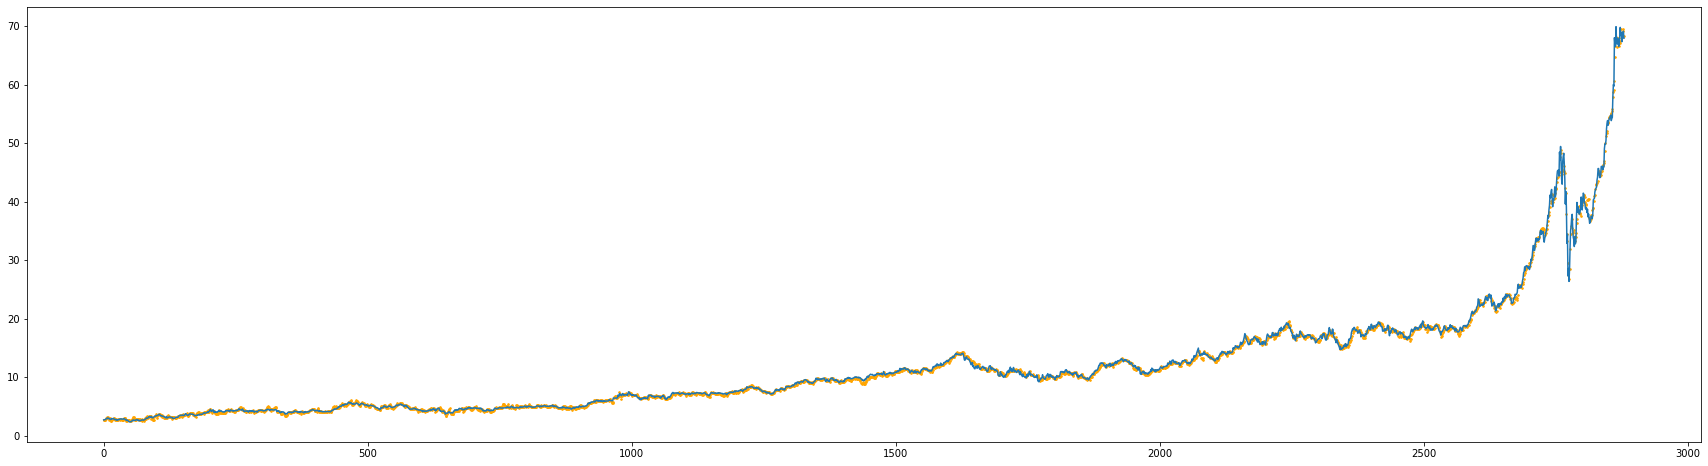

In [92]:
plt.figure(figsize=(30,8))
plt.plot(train_y_)
plt.scatter(range(len(predictions_train_)), predictions_train_, s=10, c='orange', marker='.')
plt.show()

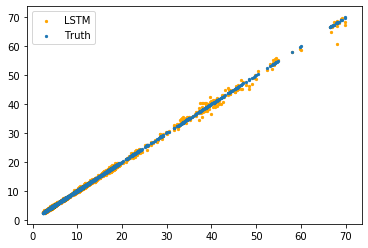

In [224]:
fig, ax = plt.subplots()
ax.scatter(train_y_, predictions_train_,s=5, c="orange", label="LSTM")
ax.scatter(train_y_, train_y_,s=5, label="Truth")
# ax.plot(train_y_, train_y_)
ax.legend()

## Testing the model

In [94]:
test_data = pd.read_csv(os.path.join(test_data_dir, "test.csv"), header=None, names=None)
    
test_y = test_data[[0]].values
test_y = torch.from_numpy(test_y).float()

test_X = test_data.drop([0], axis=1).values
test_X = torch.from_numpy(test_X).float().unsqueeze(1)
test_X

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.7578, 0.7797, 0.7728]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.7901, 0.7869, 0.7756]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.7846, 0.7864, 0.7877]],

        ...,

        [[0.0000, 0.0000, 0.0000,  ..., 0.7428, 0.7469, 0.7324]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.7602, 0.7533, 0.7439]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.7479, 0.7526, 0.7357]]])

In [95]:
predictions = predictor.predict(test_X)

In [145]:
predictions_ = y_scaler.inverse_transform(predictions)
test_y_ = y_scaler.inverse_transform(test_y)

predictions_df = pd.DataFrame(index=test_df.index)
predictions_df["Truth"] = test_df["Close(t+1)"].values

predictions_df["LSTM"] = predictions_

predictions_df.plot(figsize=(30,8))
plt.ylabel("Price at D+1")
plt.xlabel("Date (D)")
predictions_df.to_csv("predictions/predictions_regression.csv",header=True, index=True)

In [137]:
predictions_df

,Truth,LSTM
Date,,
2020-08-17,67.67,65.968690
2020-08-18,65.85,67.554240
2020-08-19,67.19,66.173780
2020-08-20,67.57,68.142650
2020-08-21,66.44,68.704636
...,...,...
2020-10-08,76.90,71.736244
2020-10-09,79.15,72.931730
2020-10-13,80.58,74.490080


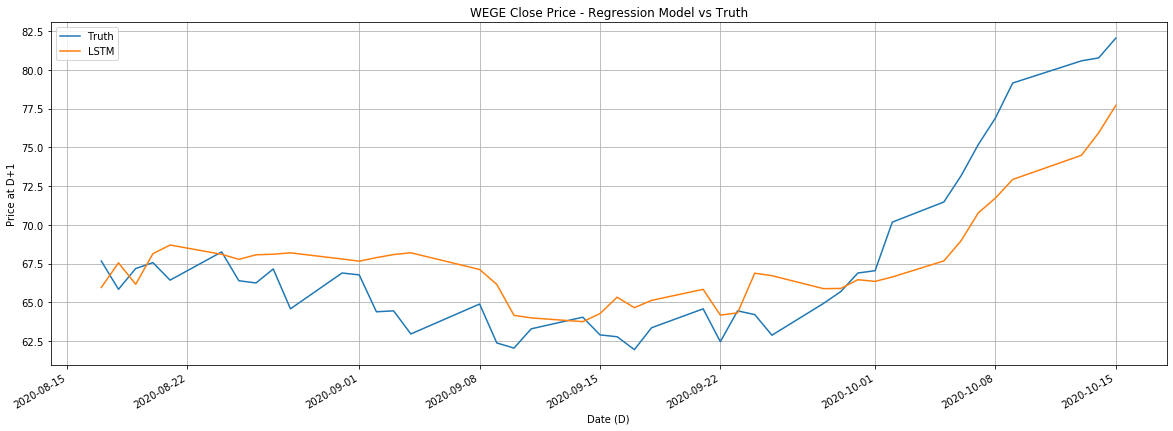

In [136]:
predictions_df = pd.read_csv("predictions/predictions_regression.csv", parse_dates=["Date"], index_col="Date")
test_y_ = predictions_df["Truth"].values
predictions_ = predictions_df["LSTM"].values
predictions_df.plot(figsize=(20,7), title = "WEGE Close Price - Regression Model vs Truth", logy=False)
plt.ylabel("Price at D+1")
plt.xlabel("Date (D)")
plt.grid()

In [99]:
from sklearn.metrics import mean_squared_error
print(f"The MSE on the test set is {mean_squared_error(predictions_,test_y_)}")

The MSE on the test set is 8.69933972482914


## Binary Classification Model

Now we'll follow a similar procedure in order to create a classification model. <br>
This model should try to predict whether the asset price will go up (1) or not (0) in a given day, based on the same data as our regression model.

In [19]:
data_binary = data.copy() # start by creating acopy of our supervised-learning dataframe
data_binary["Move_up"] = [int(boolean) for boolean in (data_binary["Close(t+1)"] > data_binary["Close"])]  # create the labels for the dataset
data_binary[["Close", "Close(t+1)", "Move_up"]]

,Close,Close(t+1),Move_up
Date,,,
2008-12-19,2.70,2.69,0
2008-12-22,2.69,2.73,1
2008-12-23,2.73,2.72,0
2008-12-26,2.72,2.75,1
2008-12-29,2.75,2.82,1
...,...,...,...
2020-10-08,75.18,76.90,1
2020-10-09,76.90,79.15,1
2020-10-13,79.15,80.58,1


1461 1461


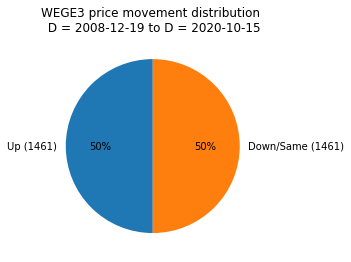

In [67]:
up_count = len(data_binary[data_binary["Move_up"] == 1])
down_same_count = len(data_binary[data_binary["Move_up"] != 1])
print(up_count, down_same_count)
fig, ax = plt.subplots()
ax.pie([up_count, down_same_count], labels=[f"Up ({up_count})",f"Down/Same ({down_same_count})"], startangle=90, autopct='%1.0f%%')
ax.set(aspect="equal", title='WEGE3 price movement distribution \n D = 2008-12-19 to D = 2020-10-15')
plt.show()

In [20]:
data_binary = data_binary.drop(["Close(t+1)"], axis="columns", errors="ignore") # drop this column since it's no longer our output

Split into test and training data as done before:

In [21]:
cut_off = datetime(2020, 8, 15) 
train_binary_df = data_binary[data_binary.index <= cut_off]
test_binary_df = data_binary[data_binary.index > cut_off]

In [22]:
dict_scalers_bn = {}
train_binary_df_scaled = pd.DataFrame(index=train_binary_df.index)
test_binary_df_scaled = pd.DataFrame(index=test_binary_df.index)

for column_name in train_binary_df.columns:
    if pd.api.types.is_numeric_dtype(train_binary_df[column_name]):
        scaler, train_binary_df_scaled[column_name] = get_scaler_and_scaled_data(train_binary_df, column_name)
        test_binary_df_scaled[column_name] = scaler.transform(test_binary_df[column_name].values.reshape(-1, 1))
        dict_scalers_bn[column_name] = scaler

In [23]:
train_data_bn_dir = 'train_data_binary'
train_binary_df_scaled.to_csv(os.path.join(train_data_bn_dir, 'train.csv'), columns=train_binary_df_scaled.columns.values[::-1], header=False, index=False)

In [24]:
test_data_bn_dir = 'test_data_binary'
test_binary_df_scaled.to_csv(os.path.join(test_data_bn_dir, 'test.csv'), columns=test_binary_df_scaled.columns.values[::-1], header=False, index=False)

In [25]:
sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix_bn = 'sagemaker/capstone/binary'

role = sagemaker.get_execution_role()

In [26]:
input_data_bn = sagemaker_session.upload_data(path=train_data_bn_dir, bucket=bucket, key_prefix=prefix_bn)
test_data_bn = sagemaker_session.upload_data(path=test_data_bn_dir, bucket=bucket, key_prefix=prefix_bn)

In [126]:
lstm_classifier = PyTorch(entry_point="train.py",
                    source_dir="train_classifier",
                    role=role,
                    framework_version='0.4.0',
                    instance_count=2,
                    instance_type='ml.m4.xlarge',
                    py_version='py3',
                    hyperparameters={
                        'epochs': 1000,
                        'input_dim': train_binary_df.shape[-1] - 1,
                        'hidden_dim': int((2/3) * (train_binary_df.shape[-1])),
                        'num_layers': 1,
                        'output_dim': 1,
                    })
lstm_classifier.hyperparameters()

{'epochs': '1000',
 'input_dim': '216',
 'hidden_dim': '144',
 'num_layers': '1',
 'output_dim': '1'}

In [127]:
min_hd = 5*int(len(train_df.index)/(10 * train_df.shape[-1]))
max_hd = 15*int(len(train_df.index)/(1 * train_df.shape[-1]))
print(min_hd,max_hd)
metric_definitions = [{'Name': 'validation:MSE',
                       'Regex': 'val_MSE: (.*?);'}]
lstm_hyperparameter_tuner_bn = HyperparameterTuner(estimator=lstm_classifier,
                                               objective_metric_name = "validation:MSE",
                                               objective_type="Minimize",
                                               metric_definitions=metric_definitions,
                                               max_jobs=10,
                                               max_parallel_jobs=2,
                                               hyperparameter_ranges={
                                                   'hidden_dim' : IntegerParameter(min_hd, max_hd),
                                                   'num_layers' : IntegerParameter(1, 2)
                                               })

5 195


In [128]:
lstm_hyperparameter_tuner_bn.fit({'training': input_data_bn, 'validation': test_data_bn})

.....................................................................................................................................................................................................................................................................................................................................................................................................!


In [129]:
lstm_classifier = lstm_hyperparameter_tuner_bn.best_estimator()
predictor_bn = lstm_classifier.deploy(initial_instance_count = 1, 
                                      instance_type = 'ml.t2.medium',
                                      endpoint_name="lstm-classifier-endpoint")


2020-11-05 01:58:02 Starting - Preparing the instances for training
2020-11-05 01:58:02 Downloading - Downloading input data
2020-11-05 01:58:02 Training - Training image download completed. Training in progress.
2020-11-05 01:58:02 Uploading - Uploading generated training model
2020-11-05 01:58:02 Completed - Training job completed
---------------!

In [112]:
predictor_bn = sagemaker.pytorch.PyTorchPredictor("lstm-classifier-endpoint")

In [179]:
test_data_bn = pd.read_csv(os.path.join(test_data_bn_dir, "test.csv"), header=None, names=None)

test_y_bn = test_data_bn[[0]].values
# test_y_bn = torch.from_numpy(test_y_bn).float()

test_X_bn = test_data_bn.drop([0], axis=1).values
test_X_bn = torch.from_numpy(test_X_bn).float().unsqueeze(1)
test_X_bn

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.7578, 0.7797, 0.7728]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.7901, 0.7869, 0.7756]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.7846, 0.7864, 0.7877]],

        ...,

        [[0.0000, 0.0000, 0.0000,  ..., 0.7428, 0.7469, 0.7324]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.7602, 0.7533, 0.7439]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.7479, 0.7526, 0.7357]]])

In [180]:
predictions_bn = predictor_bn.predict(test_X_bn)
predictions_bn_ = [(0 if num <= 0.5 else 1) for num in predictions_bn]
# Save results locally
predictions_bn_df = pd.DataFrame(index=test_binary_df.index)
predictions_bn_df["test_y"] = test_binary_df["Move_up"]
predictions_bn_df["predictions"] = predictions_bn_
predictions_bn_df.to_csv("predictions/predictions_classification.csv", header=True, index=True) # in case notebook closes and results lost from memory

In [78]:
# only run in case the notebook has been closed and results lost from memory
predictions_bn_df = pd.read_csv("predictions/predictions_classification.csv", parse_dates=["Date"], index_col="Date")
predictions_bn_ = predictions_bn_df["predictions"].values
test_y_bn = predictions_bn_df["test_y"].values

In [79]:
from sklearn.metrics import accuracy_score, recall_score, precision_score
print("Classifier model results:")
print(f"Accuracy: {accuracy_score(test_y_bn, predictions_bn_):.3f}")
print(f"Recall: {recall_score(test_y_bn, predictions_bn_):.3f}")
print(f"Precision: {precision_score(test_y_bn, predictions_bn_):.3f}")

Classifier model results:
Accuracy: 0.643
Recall: 0.800
Precision: 0.667


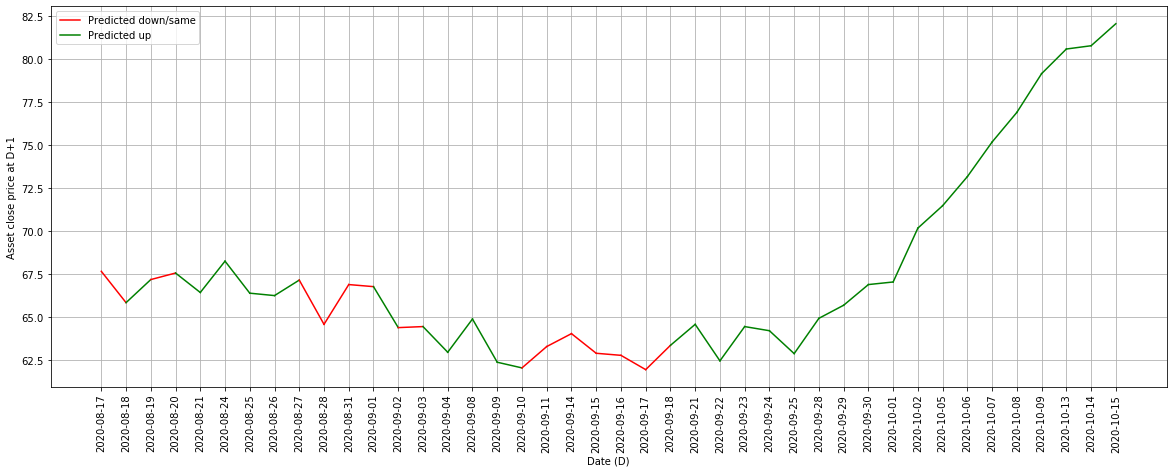

In [143]:
colors = [("green" if pred == 1 else "red") for pred in predictions_bn_]
plt.figure(figsize=(20, 7))
label_pred_up, label_pred_down = True, True
for i in range(len(predictions_bn_)-1):
    color = colors[i]
    if color == "green" and label_pred_up:
        label_pred_up = False
        label = "Predicted up"
    elif color == "red" and label_pred_down:
        label = "Predicted down/same"
        label_pred_down = False
    else:
        label = None
    plt.plot([i, i+1],[test_y_[i], test_y_[i+1]], c=colors[i], label=label)
    plt.xticks(range(len(test_binary_df.index)),test_binary_df.index.date, rotation=90)
plt.xlabel("Date (D)")
plt.ylabel("Asset close price at D+1")
plt.grid()
plt.legend()

In the plot above, the lines represent the actual prices for WEGE3 stocks.<br>
The colors represent the predictions made by our model: green lines indicate our model predicted an upward movement in price and red lines indicate the model predicted either downward movement or no movement in prices.

In [107]:
matches = []
for i in range(len(predictions_bn_)):
    if int(predictions_bn_[i]) == int(test_y_bn[i]):
        matches.append(1)
    else:
        matches.append(0)

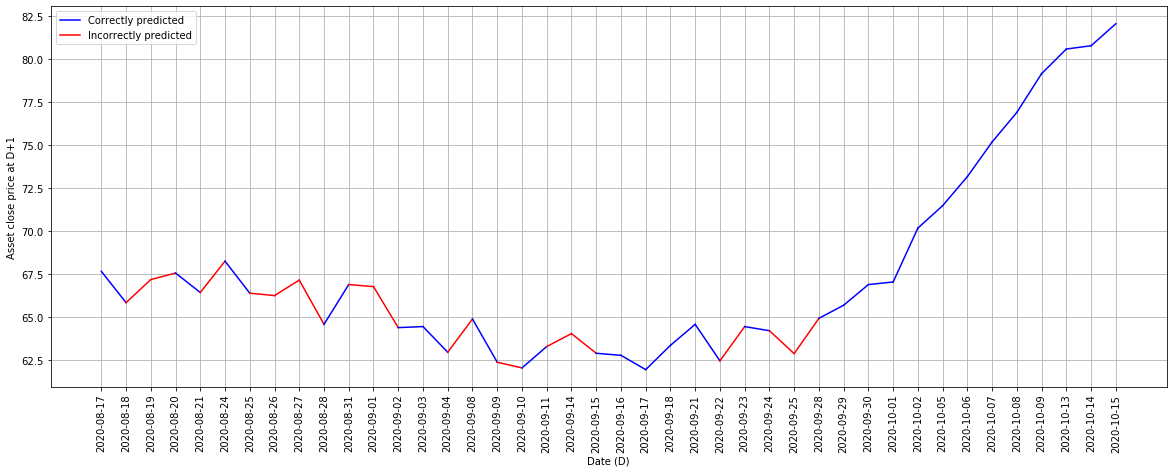

In [129]:
colors_matches = [("blue" if match == 1 else "red") for match in matches]
plt.figure(figsize=(20, 7))

label_correct, label_incorrect = True, True

for i in range(len(predictions_bn_)-1):
    if colors_matches[i] == "blue" and label_correct:
        label_correct = False
        label = "Correctly predicted"
    elif colors_matches[i] == "red" and label_incorrect:
        label = "Incorrectly predicted"
        label_incorrect = False
    else:
        label = None
    plt.plot([i, i+1],[test_y_[i], test_y_[i+1]], c=colors_matches[i], label=label)
    plt.xticks(range(len(test_binary_df.index)),test_binary_df.index.date, rotation=90, label = label)
plt.xlabel("Date (D)")
plt.ylabel("Asset close price at D+1")
plt.legend()
plt.grid()

In the plot above, the lines represent the actual prices for WEGE3 stocks.<br>
Blue lines represent movements directions that were correctly predicted by the model.
Red lines represent movements directions incorrectly predicted by teh model.

<BarContainer object of 4 artists>

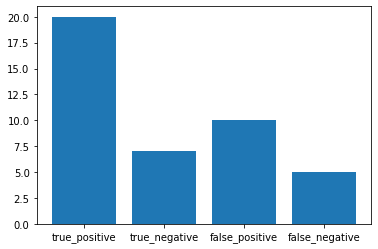

In [158]:
true_positive, true_negative, false_positive, false_negative = 0, 0, 0, 0
for i in range(len(predictions_bn_)):
    pred = predictions_bn_[i]
    truth = test_y_bn[i]
    if truth == 1 and pred == 1:
        true_positive += 1
    elif truth == 1 and pred == 0:
        false_negative += 1
    elif truth == 0 and pred == 0:
        true_negative += 1
    elif truth == 0 and pred == 1:
        false_positive += 1
plt.bar(["true_positive", "true_negative", "false_positive", "false_negative"], [true_positive, true_negative, false_positive, false_negative])

Text(0.5, 1.0, 'Counts in test set')

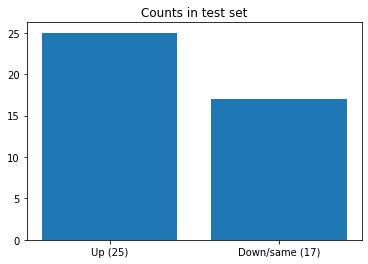

In [172]:
count_up_test = len(predictions_bn_df[predictions_bn_df["test_y"] == 1])
count_down_test = len(predictions_bn_df[predictions_bn_df["test_y"] == 0])
plt.bar([f"Up ({count_up_test})", f"Down/same ({count_down_test})"], [count_up_test, count_down_test])
plt.title("Counts in test set")

Text(0.5, 1.0, 'Counts in predictions')

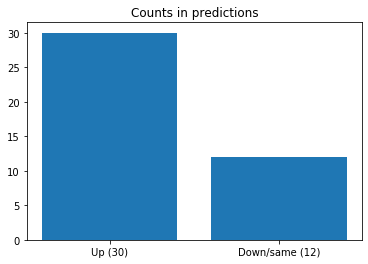

In [173]:
count_up_pred = len(predictions_bn_df[predictions_bn_df["predictions"] == 1])
count_down_pred = len(predictions_bn_df[predictions_bn_df["predictions"] == 0])
plt.bar([f"Up ({count_up_pred})", f"Down/same ({count_down_pred})"], [count_up_pred, count_down_pred])
plt.title("Counts in predictions")